# Introduction to intake-esm

This notebook demonstrates how to access Google Cloud CMIP6 data using intake-esm.

Intake-esm is a data cataloging utility built on top of intake, pandas, and
xarray. Intake-esm aims to facilitate:

- the discovery of earth’s climate and weather datasets.
- the ingestion of these datasets into xarray dataset containers.

## Imports
It's basic usage is shown below. To begin, let's import `intake`:

In [1]:
import intake

## Load the Catalog
At import time, intake-esm plugin is available in intake’s registry as
`esm_datastore` and can be accessed with `intake.open_esm_datastore()` function.
Use the `intake_esm.tutorial.get_url()` method to access smaller subsetted catalogs for tutorial purposes.

In [2]:
import intake_esm
url = intake_esm.tutorial.get_url('google_cmip6')
print(url)
cat = intake.open_esm_datastore(url)
cat

https://raw.githubusercontent.com/intake/intake-esm/main/tutorial-catalogs/GOOGLE-CMIP6.json


,unique
activity_id,1
institution_id,2
source_id,2
experiment_id,1
member_id,72
table_id,2
variable_id,3
grid_label,2
zstore,261
dcpp_init_year,0


The summary above tells us that this catalog contains 261 data assets.
We can get more information on the individual data assets contained in the
catalog by looking at the underlying dataframe created when we load the catalog:

In [3]:
cat.df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,IPSL,IPSL-CM6A-LR,historical,r2i1p1f1,Amon,va,gr,gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/histor...,NaN,20180803
1,CMIP,IPSL,IPSL-CM6A-LR,historical,r2i1p1f1,Amon,ua,gr,gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/histor...,NaN,20180803
2,CMIP,IPSL,IPSL-CM6A-LR,historical,r8i1p1f1,Oyr,o2,gn,gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/histor...,NaN,20180803
3,CMIP,IPSL,IPSL-CM6A-LR,historical,r30i1p1f1,Amon,ua,gr,gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/histor...,NaN,20180803
4,CMIP,IPSL,IPSL-CM6A-LR,historical,r30i1p1f1,Amon,va,gr,gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/histor...,NaN,20180803


The first data asset listed in the catalog contains:

- the Northward Wind (variable_id='va'), as a function of latitude, longitude, time,

- the latest version of the IPSL climate model (source_id='IPSL-CM6A-LR'),

- hindcasts initialized from observations with historical forcing (experiment_id='historical'),

- developed by theInstitut Pierre Simon Laplace (instution_id='IPSL'),

- run as part of the Coupled Model Intercomparison Project (activity_id='CMIP')

And is located in Google Cloud Storage at 'gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/r2i1p1f1/Amon/va/gr/v20180803/'.

## Finding unique entries

To get unique values for given columns in the catalog, intake-esm provides a
{py:meth}`~intake_esm.core.esm_datastore.unique` method:

Let's query the data catalog to see what models(`source_id`), experiments
(`experiment_id`) and temporal frequencies (`table_id`) are available.

In [4]:
unique = cat.unique()
unique

activity_id                                                       [CMIP]
institution_id                                             [IPSL, CCCma]
source_id                                        [IPSL-CM6A-LR, CanESM5]
experiment_id                                               [historical]
member_id              [r2i1p1f1, r8i1p1f1, r30i1p1f1, r29i1p1f1, r3i...
table_id                                                     [Amon, Oyr]
variable_id                                                 [va, ua, o2]
grid_label                                                      [gr, gn]
zstore                 [gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/histo...
dcpp_init_year                                                        []
version                         [20180803, 20190429, 20190802, 20191204]
derived_variable_id                                                   []
dtype: object

In [5]:
unique['source_id']

['IPSL-CM6A-LR', 'CanESM5']

In [6]:
unique['experiment_id']

['historical']

In [7]:
unique['table_id']

['Amon', 'Oyr']

## Search for specific datasets

The {py:meth}`~intake_esm.core.esm_datastore.search` method allows the user to
perform a query on a catalog using keyword arguments. The keyword argument names
must match column names in the catalog. The search method returns a
subset of the catalog with all the entries that match the provided query.

In the example below, we are are going to search for the following:

- variable_d: `o2` which stands for
  `mole_concentration_of_dissolved_molecular_oxygen_in_sea_water`
- experiments: ['historical', 'ssp585']:
  - historical: all forcing of the recent past.
  - ssp585: emission-driven RCP8.5 based on SSP5.
- table_id: `0yr` which stands for annual mean variables on the ocean grid.
- grid_label: `gn` which stands for data reported on a model's native grid.


For more details on the CMIP6 vocabulary, please check this
[website](http://clipc-services.ceda.ac.uk/dreq/index.html), and
[Core Controlled Vocabularies (CVs) for use in CMIP6](https://github.com/WCRP-CMIP/CMIP6_CVs)
GitHub repository.

In [8]:
cat_subset = cat.search(
    experiment_id=["historical", "ssp585"],
    table_id="Oyr",
    variable_id="o2",
    grid_label="gn",
)

cat_subset

,unique
activity_id,1
institution_id,2
source_id,2
experiment_id,1
member_id,42
table_id,1
variable_id,1
grid_label,1
zstore,67
dcpp_init_year,0


## Load datasets using `to_dataset_dict()`

Intake-esm implements convenience utilities for loading the query results into
higher level xarray datasets. The logic for merging/concatenating the query
results into higher level xarray datasets is provided in the input JSON file and
is available under `.aggregation_info` property of the catalog:

In [9]:
cat.esmcat.aggregation_control

AggregationControl(variable_column_name='variable_id', groupby_attrs=['activity_id', 'institution_id', 'source_id', 'experiment_id', 'table_id', 'grid_label'], aggregations=[Aggregation(type=<AggregationType.union: 'union'>, attribute_name='variable_id', options={}), Aggregation(type=<AggregationType.join_new: 'join_new'>, attribute_name='member_id', options={'coords': 'minimal', 'compat': 'override'}), Aggregation(type=<AggregationType.join_new: 'join_new'>, attribute_name='dcpp_init_year', options={'coords': 'minimal', 'compat': 'override'})])

To load data assets into xarray datasets, we need to use the
{py:meth}`~intake_esm.core.esm_datastore.to_dataset_dict` method. This method
returns a dictionary of aggregate xarray datasets as the name hints.

In [10]:
dset_dict = cat_subset.to_dataset_dict(
    xarray_open_kwargs={"consolidated": True, "decode_times": True, "use_cftime": True}
)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [11]:
[key for key in dset_dict.keys()]

['CMIP.CCCma.CanESM5.historical.Oyr.gn',
 'CMIP.IPSL.IPSL-CM6A-LR.historical.Oyr.gn']

We can access a particular dataset as follows:

In [12]:
ds = dset_dict["CMIP.CCCma.CanESM5.historical.Oyr.gn"]
ds

<xarray.Dataset> Size: 109GB
Dimensions:             (member_id: 35, dcpp_init_year: 1, time: 165, lev: 45,
                         j: 291, i: 360, bnds: 2, vertices: 4)
Coordinates:
  * i                   (i) int32 1kB 0 1 2 3 4 5 6 ... 354 355 356 357 358 359
  * j                   (j) int32 1kB 0 1 2 3 4 5 6 ... 285 286 287 288 289 290
    latitude            (j, i) float64 838kB dask.array<chunksize=(291, 360), meta=np.ndarray>
  * lev                 (lev) float64 360B 3.047 9.454 ... 5.375e+03 5.625e+03
    lev_bnds            (lev, bnds) float64 720B dask.array<chunksize=(45, 2), meta=np.ndarray>
    longitude           (j, i) float64 838kB dask.array<chunksize=(291, 360), meta=np.ndarray>
  * time                (time) object 1kB 1850-07-02 12:00:00 ... 2014-07-02 ...
    time_bnds           (time, bnds) object 3kB dask.array<chunksize=(165, 2), meta=np.ndarray>
    vertices_latitude   (j, i, vertices) float64 3MB dask.array<chunksize=(291, 360, 4), meta=np.ndarray>
    vertices_longitude  (j, i, vertices) float64 3MB dask.array<chunksize=(291, 360, 4), meta=np.ndarray>
  * member_id           (member_id) object 280B 'r10i1p1f1' ... 'r9i1p2f1'
  * dcpp_init_year      (dcpp_init_year) float64 8B nan
Dimensions without coordinates: bnds, vertices
Data variables:
    o2                  (member_id, dcpp_init_year, time, lev, j, i) float32 109GB dask.array<chunksize=(1, 1, 12, 45, 291, 360), meta=np.ndarray>
Attributes: (12/52)
    Conventions:                      CF-1.7 CMIP-6.2
    YMDH_branch_time_in_child:        1850:01:01:00
    activity_id:                      CMIP
    branch_method:                    Spin-up documentation
    branch_time_in_child:             0.0
    cmor_version:                     3.4.0
    ...                               ...
    intake_esm_attrs:table_id:        Oyr
    intake_esm_attrs:variable_id:     o2
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:version:         20190429
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.CCCma.CanESM5.historical.Oyr.gn

Let’s create a quick plot for a slice of the data:

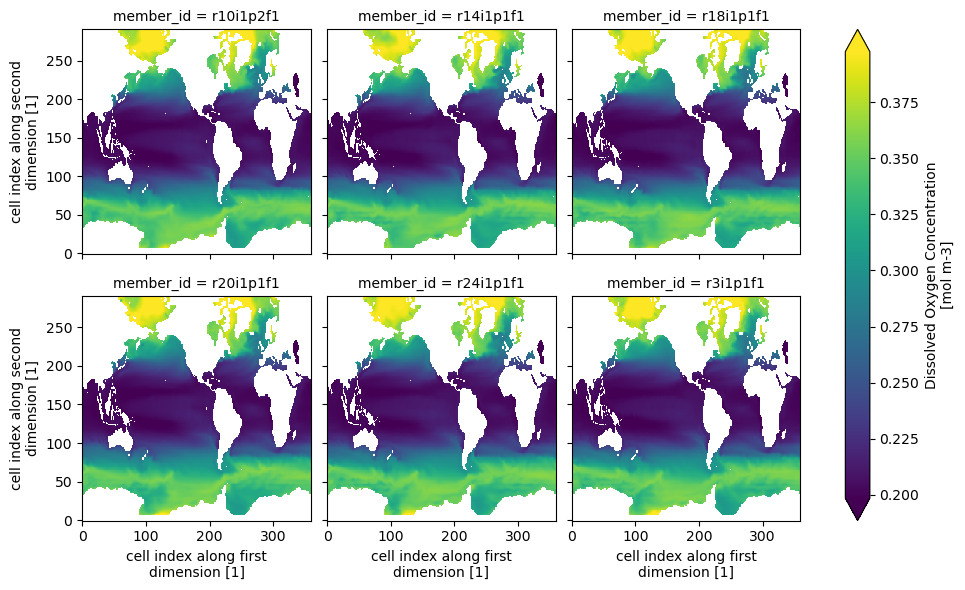

In [13]:
ds.o2.isel(time=0,
           lev=0,
           member_id=range(1, 24, 4)
          ).plot(col="member_id", col_wrap=3, robust=True)

## Use custom preprocessing functions

When comparing many models it is often necessary to preprocess (e.g. rename
certain variables) them before running some analysis step. The `preprocess`
argument lets the user pass a function, which is executed for each loaded asset
before combining datasets.

In [14]:
cat_pp = cat.search(
    experiment_id=["historical"],
    table_id="Oyr",
    variable_id="o2",
    grid_label="gn",
    source_id=["IPSL-CM6A-LR", "CanESM5"],
    member_id="r10i1p1f1",
)
cat_pp.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,IPSL,IPSL-CM6A-LR,historical,r10i1p1f1,Oyr,o2,gn,gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/histor...,NaN,20180803
1,CMIP,CCCma,CanESM5,historical,r10i1p1f1,Oyr,o2,gn,gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/historical...,NaN,20190429


In [15]:
dset_dict_raw = cat_pp.to_dataset_dict(xarray_open_kwargs={"consolidated": True})

for k, ds in dset_dict_raw.items():
    print(f"dataset key={k}\n\tdimensions={sorted(list(ds.dims))}\n")


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


dataset key=CMIP.IPSL.IPSL-CM6A-LR.historical.Oyr.gn
	dimensions=['axis_nbounds', 'dcpp_init_year', 'member_id', 'nvertex', 'olevel', 'time', 'x', 'y']

dataset key=CMIP.CCCma.CanESM5.historical.Oyr.gn
	dimensions=['bnds', 'dcpp_init_year', 'i', 'j', 'lev', 'member_id', 'time', 'vertices']



Note that both models follow a different naming scheme. We can define a little
helper function and pass it to `.to_dataset_dict()` to fix this. For
demonstration purposes we will focus on the vertical level dimension which is
called `lev` in `CanESM5` and `olevel` in `IPSL-CM6A-LR`.

In [16]:
def helper_func(ds):
    """Rename `olevel` dim to `lev`"""
    ds = ds.copy()
    # a short example
    if "olevel" in ds.dims:
        ds = ds.rename({"olevel": "lev"})
    return ds

In [17]:
dset_dict_fixed = cat_pp.to_dataset_dict(xarray_open_kwargs={"consolidated": True}, preprocess=helper_func)

for k, ds in dset_dict_fixed.items():
    print(f"dataset key={k}\n\tdimensions={sorted(list(ds.dims))}\n")


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


dataset key=CMIP.CCCma.CanESM5.historical.Oyr.gn
	dimensions=['bnds', 'dcpp_init_year', 'i', 'j', 'lev', 'member_id', 'time', 'vertices']

dataset key=CMIP.IPSL.IPSL-CM6A-LR.historical.Oyr.gn
	dimensions=['axis_nbounds', 'dcpp_init_year', 'lev', 'member_id', 'nvertex', 'time', 'x', 'y']



This was just an example for one dimension.

Check out [xmip package](https://github.com/jbusecke/xMIP)
for a full renaming function for all available CMIP6 models and some other
utilities.